In [29]:
import matplotlib.pyplot as plt
import numpy as np
from os import sep

# Weights before and after training (p=10)

In [35]:
bigruns = 'output' + sep + 'archive' + sep + 'big_runs'
trainingdir = bigruns + sep + 'rbm' + sep + 'hopfield_10hidden_0fields_2.00beta_100batch_100epochs_20cdk_1.00E-04eta_200ais'
rundir = trainingdir + sep + 'run4'
weightsfile = rundir + sep + 'weights_10hidden_0fields_20cdk_0stepsAIS_2.00beta.npz'

weights = np.load(weightsfile)['weights']
print(weights.shape)

(784, 10, 101)


globmax: 0.18854913115501404
globmin: -0.1610877960920334


c:\users\matts\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

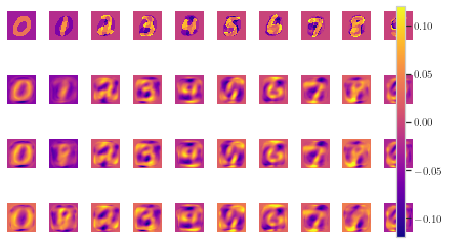

In [37]:
#columns = [0,1,2,3]
columns = list(range(0,10))
#columns = list(range(20,30))
epochs = [0, 20, 50, 100]
#epochs = [0, 100]

# TODO one cbar for all images (get min,max of data in initial loop, plot after second loop?)
# LOOP 1 (find globmin, globmax)
globmin = 0; globmax = 0
for i, epoch in enumerate(epochs):
    for j, col in enumerate(columns):
        img = weights[:, col, epoch]
        imin = np.min(img)
        imax = np.max(img)
        globmax = max(globmax, imax)
        globmin = min(globmin, imin)
print("globmax:", globmax)
print("globmin:", globmin)

globmaxForce = 0.12
globminForce = -0.12

# LOOP 2
# tried 'RdBu', 'PRGn', 'RdYlBu', 'coolwarm'
plt.figure()
fig, axarr = plt.subplots(len(epochs), len(columns))  # alt is gridspec
for i, epoch in enumerate(epochs):
    for j, col in enumerate(columns):
        img = weights[:, col, epoch].reshape(28,28)
        #im = axarr[i,j].imshow(img, interpolation='none', vmin=globmin, vmax=globmax, cmap='coolwarm')
        #im = axarr[i,j].imshow(img, interpolation='none', vmin=globminForce, vmax=globmaxForce, cmap='coolwarm')
        
        #im = axarr[i,j].imshow(img, interpolation='none', cmap='plasma')
        im = axarr[i,j].imshow(img, interpolation='none', vmin=globminForce, vmax=globmaxForce, cmap='plasma')

        axarr[i,j].axis('off')
        
        
# cax
cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
fig.tight_layout()
plt.savefig(rundir + sep + 'specified_weights.pdf')
plt.show()


# Generative performance of Hopfield weights: k vs beta

In [179]:
# forked from plotting.py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from settings import DIR_OUTPUT

In [180]:
import matplotlib as mpl
mpl.rcParams["mathtext.default"]
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = [r'\usepackage{bm}', r'\usepackage{amsmath}']
print(mpl.rcParams["text.usetex"])

True


In [527]:
err_style='band'  # band or bars
marker='o'  # 'o'
markers=True

lowbeta = False
hebbian = False
if hebbian:
    strmod = '_1000steps_1stepsRev_hebbian'
else:
    strmod = '_1000steps_100stepsRev'
if lowbeta:
    strmod += '_lowbeta'

# http://seaborn.pydata.org/tutorial/color_palettes.html
# palette: string, list, dict, or matplotlib.colors.Colormap
#palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=10)  # WORKS: cubehelix custom settings
#palette=sns.color_palette("ch:s=.25,rot=-.25,light=0.7", n_colors=10)  # WORKS: cubehelix custom settings

# choice A
#palette=sns.cubehelix_palette(n_colors=10, start=0.25, rot=-0.25, 
#                              gamma=1.0, hue=0.8, light=0.8, dark=0.15, reverse=False, as_cmap=False)
# defaults
# def cubehelix_palette(n_colors=6, start=0, rot=.4, gamma=1.0, hue=0.8, light=.85, dark=.15, as_cmap=False):
# choice B
# palette = None (same as below settings I think)
# palette = sns.cubehelix_palette(n_colors=10, start=0, rot=0.4, gamma=1.0, hue=0.8, light=0.85, dark=0.15, as_cmap=False)
# choice C
#palette = sns.cubehelix_palette(n_colors=n_colors, start=.5, rot=-.75)
# choice D
#palette = sns.cubehelix_palette(n_colors=10, start=0, rot=0.4, gamma=1.0, hue=0.8, light=0.85, dark=0.15, as_cmap=False)

#palette = None  # revert to C after fixing n_colors issue
#print(len(palette))

def plot_hopfield_generative_scores():
    
    k_list = list(range(1,11)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    n_colors = len(k_list)

    palette = sns.cubehelix_palette(n_colors=len(k_list), start=.5, rot=-.75)  # see notebook for alt choices
    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    figsize=(4,3)  # single column (4,3) estimate
    
    data_folder = DIR_OUTPUT + os.sep + 'archive' + os.sep + 'big_runs' + os.sep + 'hopfield' + os.sep + 'updated_AIS_runs_TODO'
    out_dir = DIR_OUTPUT + os.sep + 'logZ' + os.sep + 'hopfield'

    beta_name = r'$\beta$'
    k_name = r'$k$'
    termA_name = r'$- \beta \langle H(s) \rangle$'
    score_fwd_name = r'$\frac{1}{M}\sum_a \ln p_{\boldsymbol{\theta}}(\mathbf{s}_a)$'
    score_rev_name = r'$\frac{1}{M}\sum_a \ln p_{\boldsymbol{\theta}}(\mathbf{s}_a) \textrm{ (reverse)}$'
    LogZ_fwd_name = r'$\ln \ Z$'
    LogZ_rev_name = r'$\ln \ Z \textrm{ (reverse)}$'

    # need to crate pandas object to pass to sns lineplot https://seaborn.pydata.org/generated/seaborn.lineplot.html
    # example: replace event column elements with 'k' https://github.com/mwaskom/seaborn-data/blob/master/fmri.csv
    df1 = pd.DataFrame({beta_name: [], k_name: [], termA_name: [],
                        score_fwd_name: [], LogZ_fwd_name: [],
                        score_rev_name: [], LogZ_rev_name: []})
    for k in k_list:
        npzpath = data_folder + os.sep + 'objective_%dpatterns%s.npz' % (k, strmod)
        dataobj = np.load(npzpath)
        runs = dataobj['termA'].shape[0]
        print("runs", runs)
        for b, beta in enumerate(dataobj['beta']):
            for idx in range(runs):
                datarow = [{beta_name: beta, k_name: k, termA_name: dataobj['termA'][idx, b], 
                            score_fwd_name: dataobj['score_fwd'][idx, b], LogZ_fwd_name: dataobj['logZ_fwd'][idx, b],
                            score_rev_name: dataobj['score_rev'][idx, b], LogZ_rev_name: dataobj['logZ_rev'][idx, b]}]
                df1 = df1.append(datarow, ignore_index=True)

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=beta_name, y=termA_name, hue=k_name, marker='o', markers=True, dashes=False, data=df1,
                      legend='full', palette=palette)
    plt.savefig(out_dir + os.sep + 'kvary_termA.pdf')
    plt.show()
    plt.close()

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=beta_name, y=score_fwd_name, hue=k_name, marker=marker, markers=markers, dashes=False, data=df1,
                      legend='full', palette=palette, err_style=err_style)
    plt.legend(fontsize='x-small', loc='lower left', ncol=2)
    ax.tick_params(axis='both', which='major', pad=-1)
    #plt.ylim(-1200,-110)
    # For gridlines soften
    ax.tick_params(grid_alpha=0.35)
    plt.savefig(out_dir + os.sep + 'kvary_scores_fwd.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=beta_name, y=score_rev_name, hue=k_name, marker=marker, markers=markers, dashes=False, data=df1,
                      legend='full', palette=palette, err_style=err_style)
    plt.legend(fontsize='x-small', loc='lower left', ncol=2)
    ax.tick_params(axis='both', which='major', pad=-1)
    #plt.ylim(-1200,-110)
    plt.savefig(out_dir + os.sep + 'kvary_scores_rev.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=beta_name, y=LogZ_fwd_name, hue=k_name, marker=marker, markers=markers, dashes=False, data=df1,
                      legend='full', palette=palette, err_style=err_style)
    plt.savefig(out_dir + os.sep + 'kvary_logZ_fwd.pdf')
    #plt.xlim(0.5,3)
    plt.show()
    plt.close()
    
    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=beta_name, y=LogZ_rev_name, hue=k_name, marker=marker, markers=markers, dashes=False, data=df1,
                      legend='full', palette=palette, err_style=err_style)
    plt.savefig(out_dir + os.sep + 'kvary_logZ_rev.pdf')
    plt.show()
    plt.close()

    return

runs 3
runs 3
runs 3
runs 3
runs 3
runs 3
runs 3
runs 3
runs 3
runs 3


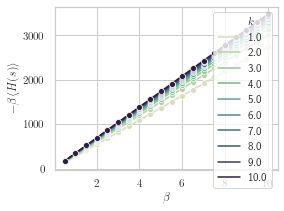

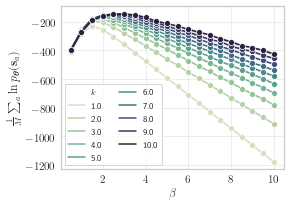

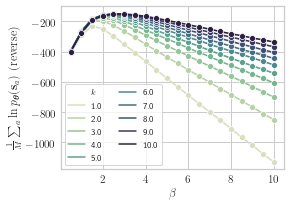

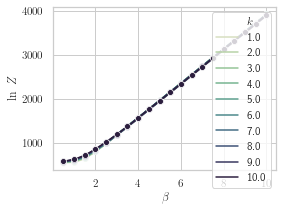

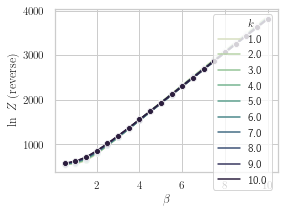

In [528]:
plot_hopfield_generative_scores()

# Generative performance of Trained RBMs

In [105]:
# forked from plotting.py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from settings import DIR_OUTPUT

In [351]:
import matplotlib as mpl
mpl.rcParams["mathtext.default"]
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = [r'\usepackage{bm}', r'\usepackage{amsmath}']
print(mpl.rcParams["text.usetex"])

sns.set()
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

True


In [352]:
figsize=(4,3)  # single column (4,3) estimate

In [353]:
def compare_generative_scores(plotting_dict, out_dir):

    epoch_name = 'epoch'
    category_name = r'$Initial_weights$'
    score_name = r'$\frac{1}{M}\sum_a \ln p_{\boldsymbol{\theta}}(\mathbf{s}_a)$'  # or dfrac?
    termA_name = r'$- \beta \langle H(s) \rangle$'
    LogZ_name = r'$\ln \ Z$'

    # need to crate pandas object to pass to sns lineplot https://seaborn.pydata.org/generated/seaborn.lineplot.html
    # example: replace event column elements with 'k' https://github.com/mwaskom/seaborn-data/blob/master/fmri.csv
    df1 = pd.DataFrame({epoch_name: [], category_name: [], score_name: [], termA_name: [], LogZ_name: []})

    for k, v in plotting_dict.items():
        for idx, epoch in enumerate(v['epochs']):
            datarow = [{epoch_name: epoch,
                        category_name: v['category'],
                        score_name: v['score'][idx],
                        termA_name: v['termA'][idx],
                        LogZ_name: v['logZ'][idx]}]
            df1 = df1.append(datarow, ignore_index=True)

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=epoch_name, y=score_name, hue=category_name, dashes=False, legend='full', data=df1)
    #ax = sns.lineplot(x=epoch_name, y=score_name, hue=category_name, marker='o', markers=True, dashes=False, data=df1,
    #                  legend='full')
    #plt.ylim(-500,0)
    #plt.ylim(-250,-50)
    plt.savefig(out_dir + os.sep + 'scores_ipynb.pdf')
    plt.show(); plt.close()

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=epoch_name, y=termA_name, hue=category_name, marker='o', markers=True, dashes=False, data=df1,
                      legend='full')
    plt.savefig(out_dir + os.sep + 'termA_ipynb.pdf')
    plt.show(); plt.close()

    plt.figure(figsize=figsize)
    ax = sns.lineplot(x=epoch_name, y=LogZ_name, hue=category_name, marker='o', markers=True, dashes=False, data=df1,
                      legend='full')
    plt.savefig(out_dir + os.sep + 'logZ_ipynb.pdf')
    plt.show(); plt.close()

    return


def compare_generative_scores_sep(plotting_dict, out_dir):
    epoch_name = 'epoch'
    category_name = r'$Initial_weights$'
    score_name = r'$\frac{1}{M}\sum_a \ln p_{\boldsymbol{\theta}}(\mathbf{s}_a)$'  # or dfrac?
    termA_name = r'$- \beta \langle H(s) \rangle$'
    LogZ_name = r'$\ln \ Z$'

    kwdict = {r'$\bf{W}_\mathrm{init}=\mathrm{Hopfield} (QR)$':
                  {'c': '#1f77b4', 'z':3},
              r'$(\bf{W}_\mathrm{init})_{i\mu}\sim\mathcal{N}(0,0.01)$':
                  {'c': '#ff7f0e', 'z':2},
              r'$\bf{W}_\mathrm{init}=\mathrm{Hopfield} (QR)$ + biases':
                  {'c': '#1f77b4', 'z': 3, 'linestyle': '--'},
              r'$(\bf{W}_\mathrm{init})_{i\mu}\sim\mathcal{N}(0,0.01)$ + biases':
                  {'c': '#ff7f0e', 'z': 2, 'linestyle': '--'}
              }

    plt.figure(figsize=figsize)
    for k, v in plotting_dict.items():
        print(k)
        print(kwdict[v['category']])
        print(kwdict[v['category']]['c'])
        print(kwdict[v['category']]['z'])
        plt.plot(v['epochs'], v['score'], label=v['title'], alpha=0.8,
                 color=kwdict[v['category']]['c'], zorder=kwdict[v['category']]['z'])
    plt.xlabel(epoch_name); plt.ylabel(score_name)
    #plt.legend()
    plt.ylim(-155,-145)  # plt.ylim(-500,0)
    plt.savefig(out_dir + os.sep + 'scores_sep_ipynb.pdf')
    plt.show(); plt.close()

    return

hopfield00 [-253.64237685 -172.67558378 -160.98204552 -155.8480679  -152.95327377]

hopfield10 [-256.25387618 -172.7023292  -160.29985994 -156.13313427 -154.3347191 ]

hopfield20 [-256.61271514 -171.43595978 -160.36986012 -157.20658737 -153.63621628]

hopfield30 [-254.12316118 -172.10024044 -162.93553782 -156.28691648 -152.38270879]

hopfield40 [-253.61294858 -173.42661023 -161.2095958  -156.85003529 -153.51116584]

normal00 [-4665.81210503  -501.55632206  -426.23819373  -396.44659975
  -362.04222585]

normal10 [-4713.94662958  -561.01705728  -484.37200028  -465.28668237
  -415.55016909]

normal20 [-4620.20352356  -568.22966403  -488.48722724  -463.00522623
  -420.28654001]

normal30 [-4819.35263227  -515.85430442  -447.25867445  -385.23983234
  -355.98004996]

normal40 [-4623.35913612  -501.70247798  -439.42670013  -385.71115163
  -344.59310544]

dict_keys(['hopfield00', 'hopfield10', 'hopfield20', 'hopfield30', 'hopfield40', 'normal00', 'normal10', 'normal20', 'normal30', 'normal40']

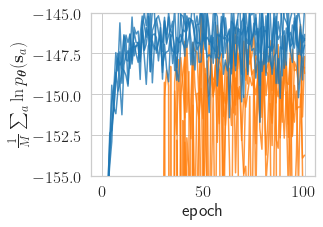

foo2...


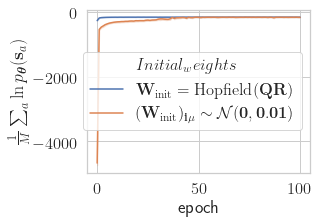

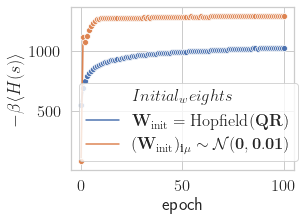

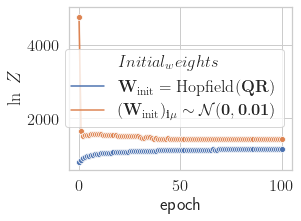

In [354]:
scores_to_compare = DIR_OUTPUT + os.sep + 'archive' + os.sep + 'big_runs' + os.sep + 'scores_to_compare'
compare_dir = scores_to_compare + os.sep + 'sept24_hopfield_vs_normal_10p_100batch_1e-4eta'

def get_category(plot_key, use_fields):
    post = ''
    if use_fields:
        post = ' + biases'

    if plot_key[0:3] == 'hop':
        val = r'$\bf{W}_\mathrm{init}=\mathrm{Hopfield} (QR)$' + post
    elif plot_key[0:3] == 'nor':
        val = r'$(\bf{W}_\mathrm{init})_{i\mu}\sim\mathcal{N}(0,0.01)$' + post
    else:
        print("plot_key invalid:", plot_key)
        return None, False
    return val, True

plotting_dict = {}
onlynpz = [f for f in os.listdir(compare_dir) if
           (os.path.isfile(os.path.join(compare_dir, f)) and f[-4:] == '.npz')]
for f in onlynpz:
    f_info = f.split('_')
    plot_key = f_info[-1][:-4]
    use_fields = bool( int(f_info[2][0]) )
    plot_key += f_info[2][0]
    
    dataobj = np.load(compare_dir + os.sep + f)
    print(plot_key, dataobj['score'][0:5])
    print()
    category, success = get_category(plot_key, use_fields)
              
    if success:
        plotting_dict[plot_key] = \
            {'epochs': dataobj['epochs'],
             'termA': dataobj['termA'],
             'logZ': dataobj['logZ'],
             'score': dataobj['score'],
             'category': category,
             'title': plot_key}

print(plotting_dict.keys())
    
print('foo1...')
compare_generative_scores_sep(plotting_dict, compare_dir)
print('foo2...')
compare_generative_scores(plotting_dict, compare_dir)

# Generative performance of Hopfield weights: Extra AIS checks

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import tensorflow as tf
import tensorflow_probability as tfp
import torch

import pandas as pd
import seaborn as sns; sns.set()

from custom_rbm import RBM_gaussian_custom
from plotting import image_fancy
from RBM_train import load_rbm_hopfield, TRAINING
from RBM_assess import get_X_y_dataset
from settings import DIR_OUTPUT, DIR_MODELS


from AIS import esimate_logZ_with_AIS, esimate_logZ_with_reverse_AIS_algo2, manual_AIS, manual_AIS_reverse, manual_AIS_reverse_algo3, subsample_test_cases, get_obj_term_A


# foos
"""
esimate_logZ_with_AIS(weights, field_visible, field_hidden, beta=1.0, num_chains=100, num_steps=1000)
esimate_logZ_with_reverse_AIS_algo2(rbm, weights, field_visible, field_hidden, beta=1.0, num_chains=100, num_steps=1000, CDK=100):

manual_AIS(rbm, beta, nchains=100, nsteps=10, CDK=1, joint_mode=True)
manual_AIS_reverse(rbm, beta, test_cases, nchains=100, nsteps=10, CDK=1, joint_mode=True)
manual_AIS_reverse_algo3(rbm, beta, test_cases, nchains=100, nsteps=10, CDK=1)
"""

foo_names = ['ais_TF', 'ais_manual', 'ais_rev', 'ais_rev3']
foo = 'ais_manual'

k_choice = 1
beta = 2.0
hebbian = ''  # either '_hebbian' or ''

nsteps = 1000        # main plot: 1000  (orig: 200)
nchains = 100         # main plot: 500  (orig: 100)
rev_ntest = 50        # main plot: 100 
rev_nsteps = 1000     # main plot: 100
rev_nchains = 50      # main plot: 50

score_too = True

load_trained_instead = True
restart = True
if restart:
    fmod = '_restart'
else:
    fmod = ''

(784, 50) 784 50
torch.Size([784, 50]) (784,) (50,)
1000 100


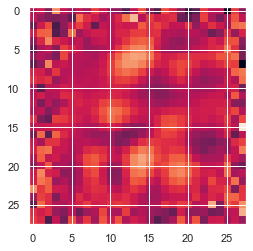

Starting AIS run with fn "ais_manual"...
step 100
step 200
step 300
step 400
step 500
step 600
step 700
step 800
step 900
step 1000
(foo) log Z: 2958.252897708466 (beta=2.00, kpatterns=1)
getting obj_term_A...
log p(data): -365.57403785281895 (beta=2.00, A=2592.68, B=2958.25)


In [19]:
# prep dataset
training_subsample = TRAINING[:]
X, _ = get_X_y_dataset(training_subsample, dim_visible=28**2, binarize=True)
RAISE_test_cases = subsample_test_cases(X, rev_ntest)

# load trained model instead
if load_trained_instead:
    epoch = 20
    VISIBLE_UNITS = 28 ** 2
    hidden_units = 50
    CD_K = 20
    run = 1
    bigruns = DIR_OUTPUT + os.sep + 'archive' + os.sep + 'big_runs' + os.sep + 'rbm'
    model_dir = 'normal_%dhidden_0fields_2.00beta_100batch_100epochs_20cdk_1.00E-04eta_200ais' % hidden_units
    model_path = bigruns + os.sep + model_dir + os.sep + 'run%d%s' % (run, fmod) + os.sep + \
        'weights_%dhidden_0fields_20cdk_0stepsAIS_2.00beta.npz' % hidden_units
    weights_timeseries_np = np.load(model_path)['weights']
    weights_loaded = weights_timeseries_np[:, :, epoch]
    N = weights_loaded.shape[0]
    p = weights_loaded.shape[1]
    
else:
    fname = 'hopfield_mnist_%d0%s.npz' % (k_choice, hebbian)
    rbm_oldclass = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)
    weights_loaded = rbm_oldclass.internal_weights
    N = rbm_oldclass.dim_visible
    p = rbm_oldclass.dim_hidden
    
rbm = RBM_gaussian_custom(N, p, 0, init_weights=None, use_fields=False, learning_rate=0)
rbm.weights = torch.from_numpy(weights_loaded).float()
zero_field_visible = np.zeros(N)
zero_field_hidden = np.zeros(p)

print(weights_loaded.shape, N, p)
print(rbm.weights.shape, zero_field_visible.shape, zero_field_hidden.shape)
print(nsteps, nchains)

plt.imshow(weights_loaded[:,1].reshape(28,28))
plt.show()

# install model into new class (compatible with AIS)

# Run AIS
print('Starting AIS run with fn "%s"...' % foo)

if foo == 'ais_TF': 
    logZ, _ = esimate_logZ_with_AIS(rbm.weights, zero_field_visible, zero_field_hidden, beta=beta, num_chains=nchains, num_steps=nsteps)
elif foo == 'ais_manual': 
    logZ, _ = manual_AIS(rbm, beta, nchains=nchains, nsteps=nsteps)
elif foo == 'ais_rev':
    logZ, _ = manual_AIS_reverse(rbm, beta, RAISE_test_cases, nchains=rev_nchains, nsteps=rev_nsteps)
elif foo == 'ais_rev3':
    logZ, _ = manual_AIS_reverse_algo3(rbm, beta, RAISE_test_cases, nchains=rev_nchains, nsteps=rev_nsteps)
else:
    assert foo in foo_names

print('(foo) log Z:', logZ, '(beta=%.2f, kpatterns=%d)' % (beta, k_choice))
    
if score_too:
    print('getting obj_term_A...')
    obj_term_A = get_obj_term_A(X, weights_loaded, zero_field_visible, zero_field_hidden, beta=beta)
    
    score = obj_term_A - logZ
    print('log p(data):', score, '(beta=%.2f, A=%.2f, B=%.2f)' % (beta, obj_term_A, logZ))

# Plot classification error vs epoch (for multiple k)

In [383]:
# forked from plotting.py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from settings import DIR_OUTPUT

import matplotlib as mpl
mpl.rcParams["mathtext.default"]
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = [r'\usepackage{bm}', r'\usepackage{amsmath}']
print(mpl.rcParams["text.usetex"])

sns.set()
sns.set(font_scale=1.3)
sns.set_style("whitegrid")

True


In [522]:
def plot_classify_dict(plotting_dict, k_to_plot, out_dir, figsize=(4,3)):
    
    epoch_name = r'$\textrm{epoch}$'
    category_name = r'$Initial_weights$'
    error_name = r'$\textrm{Test error (\%)}$'  # or dfrac?
    k_name = r'$k$'
    
    #plt.figure() 
    plt.figure(figsize=figsize)
    for a in ['norm', 'hopf']:
        for k in k_to_plot:
            klabel = r'$k=%d$' % k
            vc = plotting_dict[a][klabel]
            
            plt.errorbar(vc['x'], vc['y_mean'], yerr=vc['y_err'],
                         marker=vc['marker'], 
                         label=plotting_dict[a]['label'] + klabel, 
                         color=plotting_dict[a]['c'], 
                         linestyle=plotting_dict[a]['ls'],
                         alpha=0.8,
                         markersize=2,
                         linewidth=0.5,
                         markeredgecolor='k',
                         markeredgewidth=0.5,
                         elinewidth=1,
                         capsize=2)

    plt.xlabel(epoch_name); plt.ylabel(error_name)
    #plt.legend()
    plt.ylim(1, 11.9)  # plt.ylim(1.5, 9.9)
    plt.xlim(-0.2, 50.5)
    plt.savefig(out_dir + os.sep + 'errors2.pdf', bbox_inches='tight')
    plt.show(); plt.close()

    return

def plot_classify_dict_expt(plotting_dict, k_to_plot, out_dir, figsize=(4,3)):

    epoch_name = r'$\textrm{epoch}$'
    category_name = r'$Initial_weights$'
    error_name = r'$\textrm{Test error (\%)}$'  # or dfrac?
    k_name = r'$k$'
    
    #plt.figure() 
    plt.figure(figsize=figsize)
    for a in ['norm', 'hopf']:

        for k in k_to_plot:
            klabel = r'$k=%d$' % k
            vc = plotting_dict[a][klabel]
            plt.errorbar(vc['x'], vc['y_mean'], yerr=vc['y_err'],
                         marker=vc['marker'], 
                         label=plotting_dict[a]['label'] + klabel, 
                         color=plotting_dict[a]['c'], 
                         linestyle=plotting_dict[a]['ls'],
                         alpha=0.8,
                         markersize=4,
                         linewidth=0.5,
                         markeredgecolor='k',
                         markeredgewidth=0.5,
                         ecolor='k',
                         elinewidth=1,
                         capsize=2,
                         zorder=plotting_dict[a]['z'])

            """plt.fill_between(
                vc['x'],                 
                vc['y_mean'] - vc['y_err'][0,:],
                vc['y_err'][1,:] - vc['y_mean'],
                color='gray', alpha=0.2)"""
            
            plt.fill_between(
                vc['x'],                 
                vc['y_mean'] - vc['y_err'][0,:],
                vc['y_mean'] + vc['y_err'][1,:],
                color=plotting_dict[a]['c'], #color='gray', 
                alpha=0.2)

            print(vc['y_err'][1,:] - vc['y_mean'],)

    plt.xlabel(epoch_name); plt.ylabel(error_name)
    #plt.legend()
    plt.ylim(1, 11.9)  # plt.ylim(1.5, 9.9)
    plt.xlim(-0.2, 50.5)
    
    plt.xticks(np.arange(50, 51, 10.0))
    
    plt.savefig(out_dir + os.sep + 'errors2_expt.pdf', bbox_inches='tight')
    plt.show(); plt.close()

    return

In [523]:
import scipy as sp

scores_to_compare = DIR_OUTPUT + os.sep + 'archive' + os.sep + 'big_runs' + os.sep + 'scores_to_compare'
compare_dir = scores_to_compare + os.sep + 'sept27_classify_poe'

K_TO_KEEP = [10, 20, 100] #[1,10,100,500]

k_to_marker = {1: 'o',
              10: 'o',
              20: 's',
              100: '^',
              200: 'o',
              250: '*',
              300: '*',
              500: '*'}

plotting_dict = {}
onlynpz = [f for f in os.listdir(compare_dir) if
           (os.path.isfile(os.path.join(compare_dir, f)) and f[-4:] == '.npz')]

# prepare plotting dict
plotting_dict = {a: 
                 {'curves': {}, 'num_runs': 0}
                 for a in ['norm', 'hopf'] 
                }
plotting_dict['norm'].update(
    [('label', r'$(\bf{W}_\mathrm{init})_{i\mu}\sim\mathcal{N}(0,0.01)$'),
     ('c', '#a77ad1'), # mediumpurple is #9370DB (alt is #a77ad1)
     ('ls', '-.'),
     ('z', 5)
    ])
plotting_dict['hopf'].update(
    [('label', r'$\bf{W}_\mathrm{init}=\mathrm{Hopfield} (QR)$'),
     ('c', '#2580d4'), # "#3498db" (alt is #2580d4) or #1f77b4 
     ('ls', '--'),
     ('z', 10)
    ])

# STEP 1: loop over the npz and gather data
for f in onlynpz:
    f_info = f.split('_')
    plot_key = f_info[-1][:-4]  # 'e.g. 'hopf', 'norm'
    plot_code = plot_key[0:4]
    assert plot_code in ['hopf', 'norm']
    
    # make sure use_fields is False
    use_fields = bool( int(f_info[2][0]) )
    #plot_key += f_info[2][0]
    assert not use_fields  # currently not supported    
    
    # load the data
    dataobj = np.load(compare_dir + os.sep + f)
    accs = dataobj['accs_epoch_by_k']
    errors_epoch_by_k = 100 * (1 - accs)    
    k_range = dataobj['k_range']
    epochs = dataobj['epochs']
    
    print(plot_code, 'entering kloop LOOP 1')
    for k_idx, k in enumerate(k_range):
        current_run = plotting_dict[plot_code]['num_runs']
        if k in K_TO_KEEP:
            curve_label = r'$k=%d$' % k
            yvals = errors_epoch_by_k[:, k_idx]            
            if curve_label in plotting_dict[plot_code].keys():
                assert (epochs == plotting_dict[plot_code][curve_label]['x']).all()
                plotting_dict[plot_code][curve_label]['y_sum'] += yvals
                plotting_dict[plot_code][curve_label]['runs'][current_run] = yvals
            else:
                print(plot_code, curve_label, current_run)
                assert current_run == 0
                plotting_dict[plot_code][curve_label] = {
                    'x': epochs,
                    'y_sum': np.copy(yvals),
                    'marker': k_to_marker[k],
                    'runs': {0: yvals}
                }
            print('in loop 1...')
            print(plot_code, k)
            print(yvals)
            print("print(plotting_dict[plot_code][curve_label]['runs'][0])")
            print(plotting_dict[plot_code][curve_label]['runs'][0])
            print('CHECK:', plotting_dict[plot_code][curve_label]['runs'][0])
            print()
    plotting_dict[plot_code]['num_runs'] += 1
                        

print("\n\nLOOP 1 keys")
print ( plotting_dict['hopf'].keys() )
print( plotting_dict['norm'].keys() )
                
# STEP 2: compute curve means and error bars
for plot_label in ['hopf', 'norm']:
    num_runs = plotting_dict[plot_code]['num_runs']
    print(num_runs,num_runs,num_runs,num_runs,num_runs)
    for k in K_TO_KEEP:
        curve_label = r'$k=%d$' % k
        ysum = plotting_dict[plot_label][curve_label]['y_sum']
        plotting_dict[plot_label][curve_label]['y_mean'] = ysum / num_runs
        
        num_runs = plotting_dict[plot_label]['num_runs']
        val_arr = np.array([plotting_dict[plot_label][curve_label]['runs'][r] 
                           for r in range(num_runs)])
        print("num_runs", num_runs)
        print("val_arr.shape", val_arr.shape)
        #val_arr = np.array(plotting_dict[plot_label][curve_label]['runs'])
        
        #y_SEM = sp.stats.sem(
        #    np.array(plotting_dict[plot_label][curve_label]['yvals_list']), axis=0)
        #y_STD = np.std(
        #    np.array(plotting_dict[plot_label][curve_label]['yvals_list']), axis=0)
        #y_err = y_STD
        
        #print('val arr col0')
        #print(val_arr[:, 0])
        
        y_upper = np.max(val_arr, axis=0) - plotting_dict[plot_label][curve_label]['y_mean']
        y_lower = plotting_dict[plot_label][curve_label]['y_mean'] - np.min(val_arr, axis=0)
        y_err = np.concatenate(([y_lower], [y_upper]))
        
        #print("y_mean")
        #print(plotting_dict[plot_label][curve_label]['y_mean'])
        #print("y_upper.shape", y_upper.shape)
        #print("y_err.shape", y_err.shape)
        #print(y_err[0,:])
        #print(y_err[1,:])
        #print(val_arr[:,0])
        plotting_dict[plot_label][curve_label]['y_err'] = y_err
        
        
        print(plot_label, k, '...')
        print(plotting_dict[plot_label][curve_label]['y_mean'])
        
print( "\n\nLOOP 2 keys" )
print( plotting_dict['hopf'].keys() )
print( plotting_dict['norm'].keys() )

hopf entering kloop LOOP 1
hopf $k=10$ 0
in loop 1...
hopf 10
[6.91 6.39 6.25 6.29 6.11 5.94 5.53 5.25 5.01 4.84 4.68 4.63 4.5  4.41
 4.46]
print(plotting_dict[plot_code][curve_label]['runs'][0])
[6.91 6.39 6.25 6.29 6.11 5.94 5.53 5.25 5.01 4.84 4.68 4.63 4.5  4.41
 4.46]
CHECK: [6.91 6.39 6.25 6.29 6.11 5.94 5.53 5.25 5.01 4.84 4.68 4.63 4.5  4.41
 4.46]

hopf $k=20$ 0
in loop 1...
hopf 20
[5.68 5.57 5.31 5.25 5.13 5.1  4.5  4.32 4.04 4.05 3.95 4.03 3.85 3.78
 3.59]
print(plotting_dict[plot_code][curve_label]['runs'][0])
[5.68 5.57 5.31 5.25 5.13 5.1  4.5  4.32 4.04 4.05 3.95 4.03 3.85 3.78
 3.59]
CHECK: [5.68 5.57 5.31 5.25 5.13 5.1  4.5  4.32 4.04 4.05 3.95 4.03 3.85 3.78
 3.59]

hopf $k=100$ 0
in loop 1...
hopf 100
[4.4  4.04 3.91 3.69 3.6  3.6  3.41 3.4  3.26 3.23 3.14 3.18 3.1  3.16
 3.05]
print(plotting_dict[plot_code][curve_label]['runs'][0])
[4.4  4.04 3.91 3.69 3.6  3.6  3.41 3.4  3.26 3.23 3.14 3.18 3.1  3.16
 3.05]
CHECK: [4.4  4.04 3.91 3.69 3.6  3.6  3.41 3.4  3.26 3.23 

dict_keys(['norm', 'hopf'])


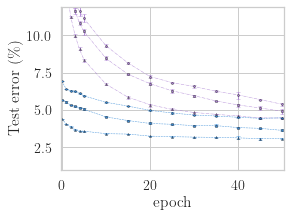

[-50.30666667 -15.79       -12.49       -11.76666667 -11.17333333
 -10.82333333  -9.15333333  -8.05        -7.12333333  -6.76
  -6.49        -6.16        -5.81        -5.64333333  -5.32666667]
[-51.8        -14.33333333 -11.88333333 -11.37666667 -10.67333333
 -10.08333333  -8.29        -7.36        -6.62333333  -6.18666667
  -5.89333333  -5.59333333  -5.25333333  -5.02        -4.76      ]
[-53.16333333 -13.15333333 -11.17666667  -9.88        -8.91333333
  -8.29333333  -6.68333333  -5.77666667  -5.27666667  -4.96333333
  -4.77666667  -4.71        -4.50666667  -4.42        -4.38666667]
[-6.91       -6.38       -6.23666667 -6.22333333 -6.09666667 -5.91
 -5.50333333 -5.25333333 -4.93666667 -4.76       -4.64666667 -4.57
 -4.47       -4.41666667 -4.45666667]
[-5.68       -5.48333333 -5.28666667 -5.20333333 -5.12333333 -4.99333333
 -4.48333333 -4.26666667 -4.03       -4.00666667 -3.90666667 -3.87666667
 -3.79666667 -3.76666667 -3.53333333]
[-4.4        -4.05       -3.87       -3.66333333 -3.6

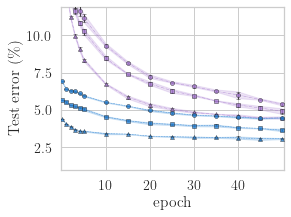

In [524]:
print(plotting_dict.keys())
plot_classify_dict(plotting_dict, K_TO_KEEP, compare_dir)
plot_classify_dict_expt(plotting_dict, K_TO_KEEP, compare_dir)

# TODO: try remove markers and just have lines with error bars

# ROUGH - Alternative mapping via eig sqrt

In [68]:
# prep dataset
from RBM_train import load_rbm_hopfield, TRAINING
from RBM_assess import get_X_y_dataset
from settings import DIR_OUTPUT, DIR_MODELS

k_choice = 1

training_subsample = TRAINING
X, _ = get_X_y_dataset(training_subsample, dim_visible=28**2, binarize=True)

# load model A
fname = 'hopfield_mnist_%d0%s.npz' % (k_choice, '')
rbm_proj = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)
weights_proj = rbm_proj.internal_weights
visible_field_proj = rbm_proj.visible_field
hidden_field_proj = rbm_proj.hidden_field

# load model B
fname = 'hopfield_mnist_%d0%s.npz' % (k_choice, '_hebbian')
rbm_hebbian = load_rbm_hopfield(npzpath=DIR_MODELS + os.sep + 'saved' + os.sep + fname)
weights_hebbian = rbm_hebbian.internal_weights
visible_field_hebbian = rbm_hebbian.visible_field
hidden_field_hebbian = rbm_hebbian.hidden_field

N = weights_proj.shape[0]
p = weights_proj.shape[1]

LOADING: models\saved\hopfield_mnist_10.npz
LOADING: models\saved\hopfield_mnist_10_hebbian.npz


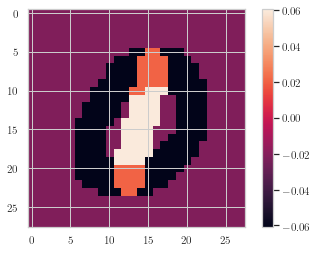

0.0012755102040816326
0.999999999999997


'\nplt.plot(visible_field_proj)\nplt.show()\n\nplt.plot(hidden_field_proj)\nplt.show()'

In [69]:
plt.imshow(weights_proj[:,1].reshape(28,28), interpolation='None')
plt.colorbar()
plt.show()

print(1.0/(28**2))
print(np.dot(weights_proj[:,1], weights_proj[:,1]))

"""
plt.plot(visible_field_proj)
plt.show()

plt.plot(hidden_field_proj)
plt.show()"""

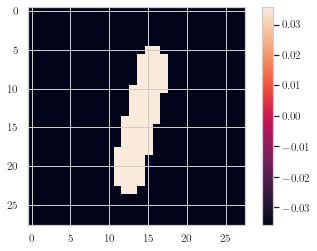

0.03571428571428571
0.9999999999999956


'plt.plot(visible_field_hebbian)\nplt.show()\n\nplt.plot(hidden_field_hebbian)\nplt.show()'

In [70]:
plt.imshow(weights_hebbian[:,1].reshape(28,28), interpolation='None')
plt.colorbar()
plt.show()
plt.show()

print(1.0/(28))
print(np.dot(weights_hebbian[:,1], weights_hebbian[:,1]))

"""plt.plot(visible_field_hebbian)
plt.show()

plt.plot(hidden_field_hebbian)
plt.show()"""

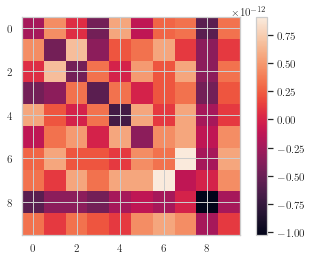

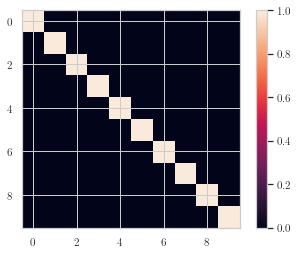

In [92]:
import scipy as sp

def mtrx_sqrt(arr):
    evals, evecs = np.linalg.eig(arr)
    print(evals)
    
    D = np.diag(evals)
    D_sqrt = np.sqrt(D)
    
    arr_sqrt = np.dot(evecs, np.dot(D_sqrt, evecs.T))
    return arr_sqrt

XI = weights_hebbian * np.sqrt(N)

A = np.dot(XI.T, XI)
A_inv = np.linalg.inv(A)
A_sqrt = sp.linalg.sqrtm(A)  #A_sqrt = mtrx_sqrt(A)
A_sqrt_inv = np.linalg.inv(A_sqrt)

K = np.dot(XI, A_sqrt_inv)

# svd of XI
U, Sigma, V = np.linalg.svd(XI, full_matrices=False)

# test that sqrt worked
plt.imshow(A - np.dot(A_sqrt.T, A_sqrt), interpolation='None')
plt.colorbar()
plt.show()

# test K orthogonal
plt.imshow(np.dot(K.T, K), interpolation='None')
plt.colorbar()
plt.show()


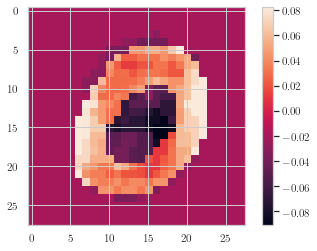

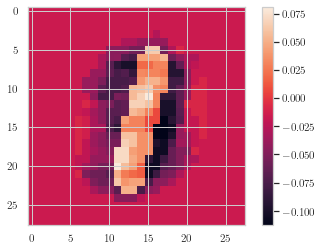

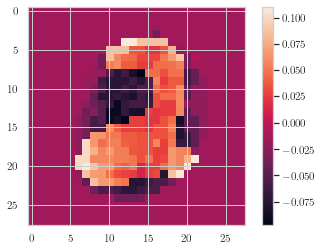

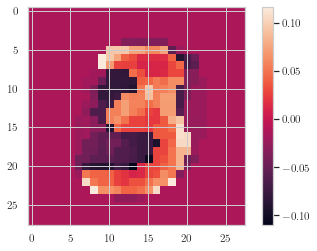

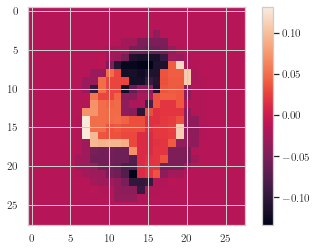

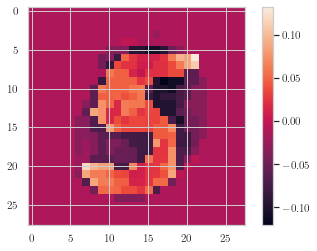

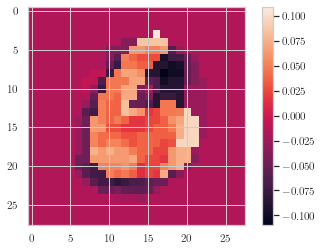

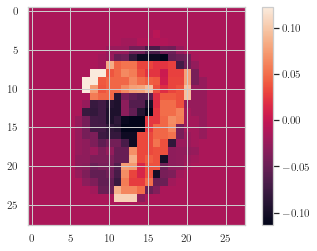

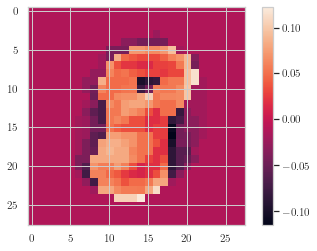

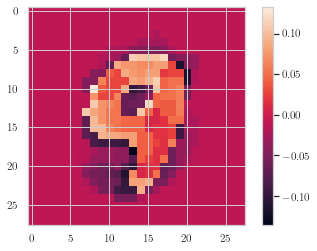

0.9999999999999978
0.9999999999999991
0.9999999999999971
1.0000000000000007
0.999999999999996
0.9999999999999978
0.9999999999999987
0.9999999999999987
0.9999999999999979
0.9999999999999971


In [97]:
# The "Square root" K-mapping
for mu in range(p):
    K_col = K[:, mu]
    XI_col = XI[:, mu] / np.sqrt(N)
    #plt.figure(figsize=(2,12))
    plt.imshow(K_col.reshape(28,28), interpolation='None')
    plt.colorbar()
    plt.show()

for mu in range(p):
    K_col = K[:, mu]
    print(np.dot(K_col, K_col))

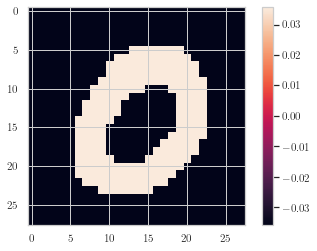

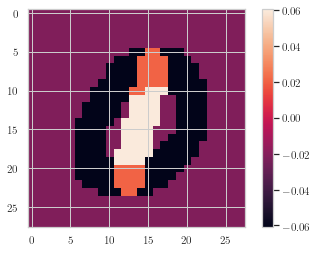

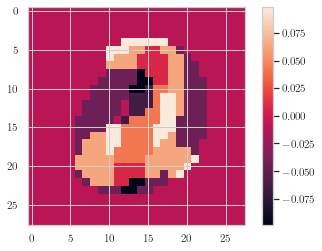

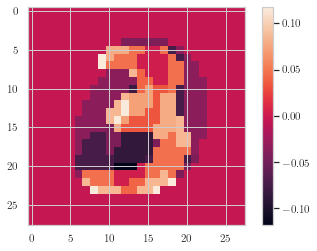

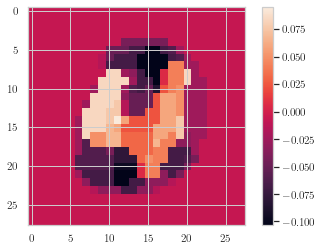

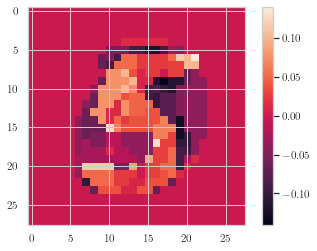

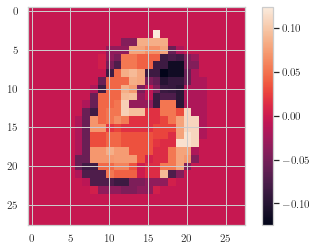

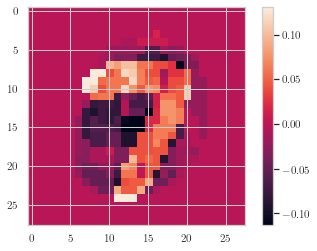

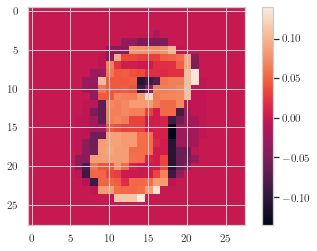

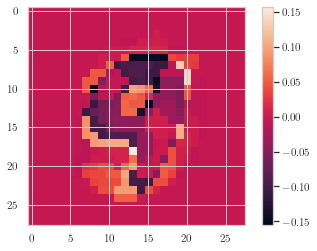

1.0000000000000009
0.999999999999997
1.0000000000000036
1.0000000000000018
0.999999999999999
1.0000000000000009
1.000000000000001
1.0000000000000033
1.0000000000000009
1.0000000000000009


In [95]:
# The "QR" Q-mapping
for mu in range(p):
    XI_col = XI[:, mu] / np.sqrt(N)
    Q_col = weights_proj[:, mu]
    #plt.figure(figsize=(2,12))
    plt.imshow(Q_col.reshape(28,28), interpolation='None')
    plt.colorbar()
    plt.show()

for mu in range(p):
    Q_col = weights_proj[:, mu]
    print(np.dot(Q_col, Q_col))

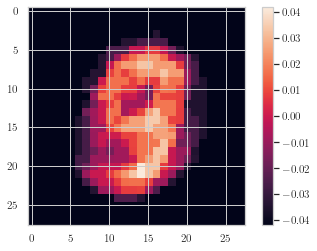

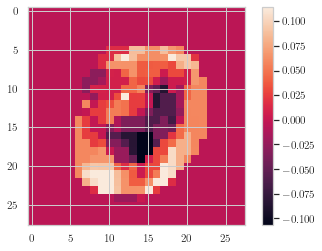

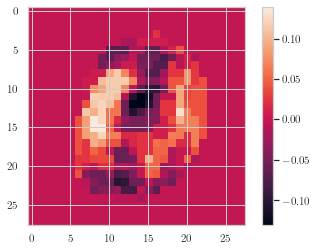

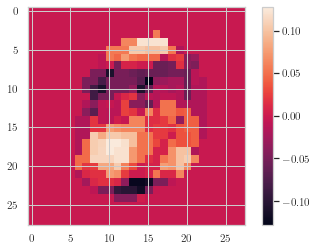

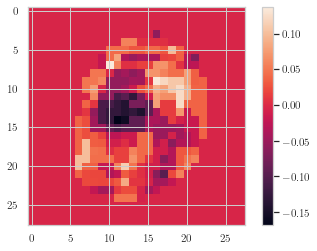

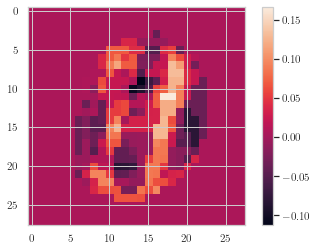

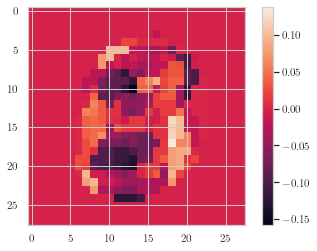

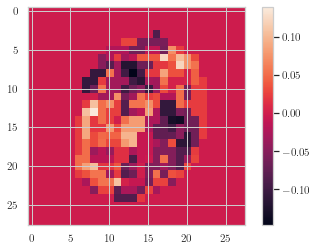

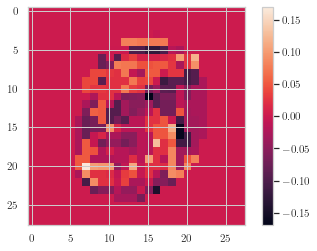

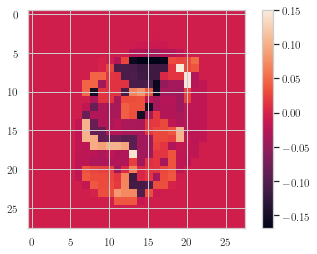

0.9999999999999986
0.999999999999998
1.0000000000000013
1.0000000000000018
0.9999999999999996
0.9999999999999991
1.0000000000000033
1.0000000000000022
1.0000000000000024
1.0000000000000007


In [96]:
# The "SVD" U-mapping
for mu in range(p):
    XI_col = XI[:, mu] / np.sqrt(N)
    U_col = U[:, mu]
    #plt.figure(figsize=(2,12))
    plt.imshow(U_col.reshape(28,28), interpolation='None')
    plt.colorbar()
    plt.show()

    
for mu in range(p):
    U_col = U[:, mu]
    print(np.dot(U_col, U_col))

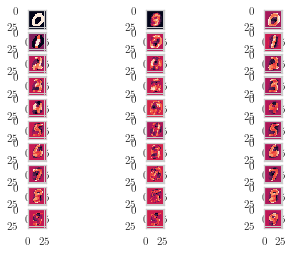

'\nfor mu in range(p):\n    K_col = K[:, mu]\n    print(np.dot(K_col, K_col))\n'

In [99]:
# The "Square root" K-mapping

fig, axarr = plt.subplots(nrows=10, ncols=3)
for mu in range(p):
    XI_col = XI[:, mu] / np.sqrt(N)    
    K_col = K[:, mu]
    U_col = U[:, mu]
    Q_col = weights_proj[:, mu]
    
    axarr[mu,0].imshow(Q_col.reshape(28,28), interpolation='None')
    #axarr[mu,0].colorbar()
    axarr[mu,1].imshow(U_col.reshape(28,28), interpolation='None')
    #axarr[mu,1].colorbar()
    axarr[mu,2].imshow(K_col.reshape(28,28), interpolation='None')
    #axarr[mu,2].colorbar()
    
plt.show()

"""
for mu in range(p):
    K_col = K[:, mu]
    print(np.dot(K_col, K_col))
"""

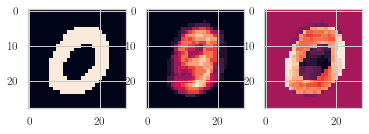

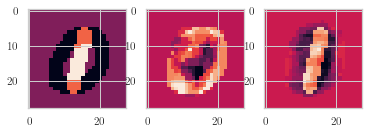

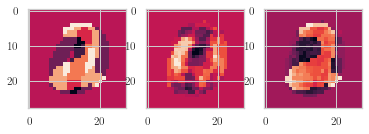

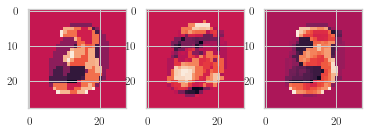

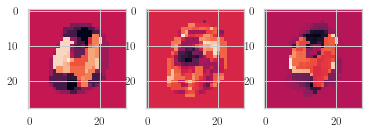

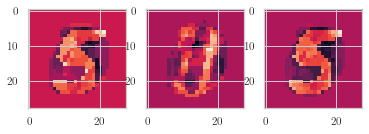

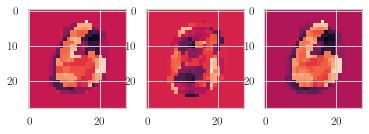

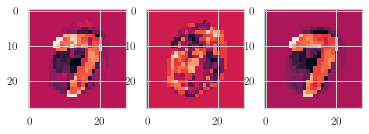

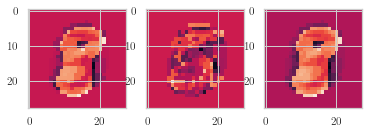

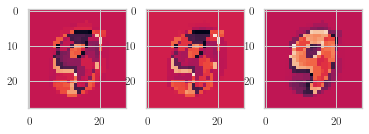

'\nfor mu in range(p):\n    K_col = K[:, mu]\n    print(np.dot(K_col, K_col))\n'

In [101]:
# The "Square root" K-mapping

for mu in range(p):
    XI_col = XI[:, mu] / np.sqrt(N)    
    K_col = K[:, mu]
    U_col = U[:, mu]
    Q_col = weights_proj[:, mu]
    
    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(Q_col.reshape(28,28), interpolation='None')
    #axarr[mu,0].colorbar()
    axarr[1].imshow(U_col.reshape(28,28), interpolation='None')
    #axarr[mu,1].colorbar()
    axarr[2].imshow(K_col.reshape(28,28), interpolation='None')
    #axarr[mu,2].colorbar()
    
    plt.show()

"""
for mu in range(p):
    K_col = K[:, mu]
    print(np.dot(K_col, K_col))
"""

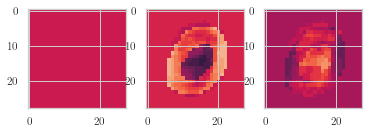

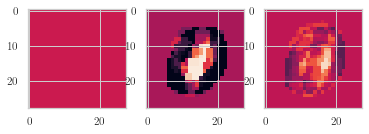

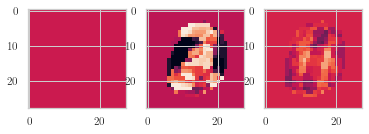

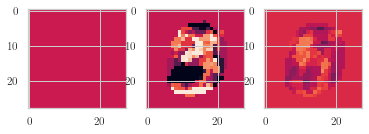

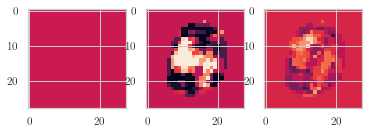

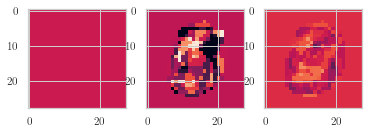

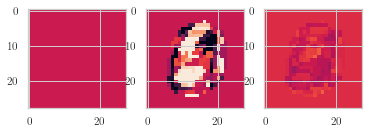

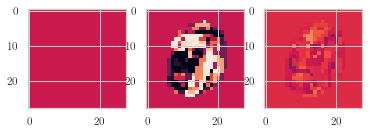

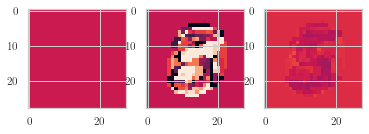

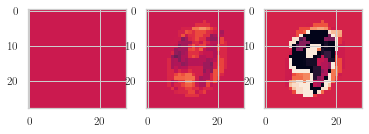

'\nfor mu in range(p):\n    K_col = K[:, mu]\n    print(np.dot(K_col, K_col))\n'

In [104]:
# The "Square root" K-mapping

for mu in range(p):
    XI_col = XI[:, mu] / np.sqrt(N)    
    K_col = K[:, mu]
    U_col = U[:, mu]
    Q_col = weights_proj[:, mu]
    
    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow((Q_col - Q_col).reshape(28,28), interpolation='None', vmin=-0.1, vmax=0.1)
    #axarr[mu,0].colorbar()
    axarr[1].imshow((Q_col - U_col).reshape(28,28), interpolation='None', vmin=-0.1, vmax=0.1)
    #axarr[mu,1].colorbar()
    axarr[2].imshow((Q_col - K_col).reshape(28,28), interpolation='None', vmin=-0.1, vmax=0.1)
    #axarr[mu,2].colorbar()
    
    plt.show()

"""
for mu in range(p):
    K_col = K[:, mu]
    print(np.dot(K_col, K_col))
"""